In [1]:
import numpy as np
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torchvision import  datasets, transforms

In [2]:
if torch.cuda.is_available() :
    DEVICE = torch.device('cuda')
else :
    DEVICE = torch.device('cpu')



print(DEVICE, torch.cuda.get_device_name(), 'torch : {}'.format(torch.__version__))

cuda NVIDIA GeForce GTX 1650 torch : 1.12.0


In [3]:
BATCH_SIZE = 128
EPOCHS = 100

In [4]:
train_dataset = datasets.CIFAR10(root = '../../data/cifar10', 
                                 download=True, 
                                 train = True,
                                 transform= transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           shuffle = True,
                                           batch_size = BATCH_SIZE)

test_dataset = datasets.CIFAR10(root = '../../data/cifar10', 
                                 download=True, 
                                 train = False,
                                 transform= transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset,
                                           shuffle = False,
                                           batch_size = BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
for (X_train, y_train) in train_loader :
    print(X_train.size(), y_train.size())
    print(X_train.type(), y_train.type())
    break

torch.Size([128, 3, 32, 32]) torch.Size([128])
torch.FloatTensor torch.LongTensor


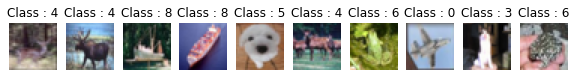

In [6]:
pltsize = 1 
plt.figure(figsize=(pltsize * 10, pltsize))
for i in range(10) :
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    # transpose로 축의 위치 순서대로 변경
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class : ' + str(y_train[i].item()))
plt.show()

In [8]:
X_train[i].shape

torch.Size([3, 32, 32])

In [10]:
np.transpose(X_train[i], (1, 2, 0)).shape

torch.Size([32, 32, 3])

In [19]:
class Net(nn.Module) :
    def __init__(self) :
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(256)
        self.dropout_prob = 0.25

    def forward(self, x) :
        x = x.view(-1, 32*32*3)
        x = self.fc1(x)
        x = self.batchnorm1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p = self.dropout_prob)
        x = self.fc2(x)
        x = self.batchnorm2(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [39]:
del model

In [40]:
import torch.nn.init as init
model = Net().to(DEVICE)
def weight_init(m) :
    if isinstance(m, nn.Linear) :
        init.kaiming_uniform_(m.weight.data)
model.apply(weight_init)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()
print(model)

Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [41]:
def train(model, train_loader, optimizer, log_intervals = 100) :
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader) :
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        output = model(image)
        optimizer.zero_grad()
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_intervals == 0 :
            print('Train_Epoch : {}, [{} / {}]({:.0f}%)\tTrain_loss : {:.6f}'.format(
                Epoch, batch_idx * len(image), len(train_loader.dataset),
                batch_idx * 100 / len(train_loader), loss.item()
            ))

In [42]:
def evaluate(model, test_loader) :
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad() :
        for image, label in test_loader :
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss = criterion(output, label)
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
        test_loss /= len(test_loader.dataset)
        test_accuracy = correct * 100 / len(test_loader.dataset)
        return test_loss, test_accuracy

In [43]:
es = 0
best_accuracy = 0

for Epoch in range(1, EPOCHS + 1) :
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print('\nEPOCH : {}, Test_loss : {:.6f}, Test_accuracy : {}\n'.format(
        Epoch, test_loss, test_accuracy
    ))

    if test_accuracy > best_accuracy :
        best_accuracy = test_accuracy
        es = 0
        best_model = model
    else :
        es += 1

    if es >= 10 :
        print(best_accuracy)
        break


Train_Epoch : 1, [0 / 50000](0%)	Train_loss : 2.785247
Train_Epoch : 1, [12800 / 50000](26%)	Train_loss : 1.732066
Train_Epoch : 1, [25600 / 50000](51%)	Train_loss : 1.739977
Train_Epoch : 1, [38400 / 50000](77%)	Train_loss : 1.800370

EPOCH : 1, Test_loss : 0.000189, Test_accuracy : 35.8

Train_Epoch : 2, [0 / 50000](0%)	Train_loss : 1.465035
Train_Epoch : 2, [12800 / 50000](26%)	Train_loss : 1.494770
Train_Epoch : 2, [25600 / 50000](51%)	Train_loss : 1.550106
Train_Epoch : 2, [38400 / 50000](77%)	Train_loss : 1.475296

EPOCH : 2, Test_loss : 0.000150, Test_accuracy : 46.91

Train_Epoch : 3, [0 / 50000](0%)	Train_loss : 1.360436
Train_Epoch : 3, [12800 / 50000](26%)	Train_loss : 1.479532
Train_Epoch : 3, [25600 / 50000](51%)	Train_loss : 1.449512
Train_Epoch : 3, [38400 / 50000](77%)	Train_loss : 1.379938

EPOCH : 3, Test_loss : 0.000122, Test_accuracy : 48.56

Train_Epoch : 4, [0 / 50000](0%)	Train_loss : 1.380660
Train_Epoch : 4, [12800 / 50000](26%)	Train_loss : 1.307642
Train_Epoc

In [57]:
class CNN(nn.Module) :
    def __init__(self) :
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels= 3,
            out_channels= 8,
            kernel_size = 3,
            padding = 1
        )
        self.conv2 = nn.Conv2d(
            in_channels= 8,
            out_channels= 16,
            kernel_size= 3,
            padding= 1
        )
        self.pool = nn.MaxPool2d(
            kernel_size= 2,
            stride = 2
        )
        self.fc1 = nn.Linear(8 * 8 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(32)
        
        self.dropout_prob = 0.25


    def forward(self, x) :
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.view(-1, 8 * 8 * 16)
        x = self.fc1(x)
        x = self.batchnorm1(x)
        x = F.relu(x)
        x = F.dropout(x, training= self.training, p = self.dropout_prob)
        x = self.fc2(x)
        x = self.batchnorm2(x)
        x = F.relu(x)
        x = F.dropout(x, training= self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

In [58]:
model2 = CNN().to(DEVICE)
model2.apply(weight_init)
optimizer = torch.optim.Adam(model2.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

In [59]:
es = 0
best_accuracy = 0

for Epoch in range(1, EPOCHS + 1) :
    train(model2, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model2, test_loader)
    print('\nEPOCH : {}, Test_loss : {:.6f}, Test_accuracy : {}\n'.format(
        Epoch, test_loss, test_accuracy
    ))

    if test_accuracy > best_accuracy :
        best_accuracy = test_accuracy
        es = 0
        best_model = model2
    else :
        es += 1

    if es >= 10 :
        print(best_accuracy)
        break


Train_Epoch : 1, [0 / 50000](0%)	Train_loss : 2.728406
Train_Epoch : 1, [12800 / 50000](26%)	Train_loss : 1.755844
Train_Epoch : 1, [25600 / 50000](51%)	Train_loss : 1.633038
Train_Epoch : 1, [38400 / 50000](77%)	Train_loss : 1.354301

EPOCH : 1, Test_loss : 0.000183, Test_accuracy : 43.21

Train_Epoch : 2, [0 / 50000](0%)	Train_loss : 1.274915
Train_Epoch : 2, [12800 / 50000](26%)	Train_loss : 1.278358
Train_Epoch : 2, [25600 / 50000](51%)	Train_loss : 1.336161
Train_Epoch : 2, [38400 / 50000](77%)	Train_loss : 1.319226

EPOCH : 2, Test_loss : 0.000109, Test_accuracy : 47.59

Train_Epoch : 3, [0 / 50000](0%)	Train_loss : 1.283275
Train_Epoch : 3, [12800 / 50000](26%)	Train_loss : 1.303069
Train_Epoch : 3, [25600 / 50000](51%)	Train_loss : 1.273192
Train_Epoch : 3, [38400 / 50000](77%)	Train_loss : 1.358563

EPOCH : 3, Test_loss : 0.000127, Test_accuracy : 57.47

Train_Epoch : 4, [0 / 50000](0%)	Train_loss : 1.298752
Train_Epoch : 4, [12800 / 50000](26%)	Train_loss : 1.273363
Train_Epo

In [60]:
best_accuracy

66.21

In [62]:
train_dataset = datasets.CIFAR10(root = '../../data/cifar10',
                                 train = True,
                                 download= True,
                                 # Compose 안에 있는 처리 과정 거친 데이터 불러옴
                                 transform= transforms.Compose([
                                    # 해당 이미지 50% 확률로 좌우 반전
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    # RGB 순으로 평균과 표준편차에 대한 정규화 실행
                                    transforms.Normalize((0.5, 0.5, 0.5),
                                                         (0.5, 0.5, 0.5))
                                 ]))
test_dataset = datasets.CIFAR10(root = '../../data/cifar10',
                                 train = False,
                                 download= True,
                                 # Compose 안에 있는 처리 과정 거친 데이터 불러옴
                                 transform= transforms.Compose([
                                    # 해당 이미지 50% 확률로 좌우 반전
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    # RGB 순으로 평균과 표준편차에 대한 정규화 실행
                                    transforms.Normalize((0.5, 0.5, 0.5),
                                                         (0.5, 0.5, 0.5))
                                 ]))
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = False)

Files already downloaded and verified
Files already downloaded and verified


In [63]:
model3 = CNN().to(DEVICE)
model3.apply(weight_init)
optimizer = torch.optim.Adam(model3.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()
es = 0
best_accuracy = 0

for Epoch in range(1, EPOCHS + 1) :
    train(model3, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model3, test_loader)
    print('\nEPOCH : {}, Test_loss : {:.6f}, Test_accuracy : {}\n'.format(
        Epoch, test_loss, test_accuracy
    ))

    if test_accuracy > best_accuracy :
        best_accuracy = test_accuracy
        es = 0
        best_model = model3
    else :
        es += 1

    if es >= 10 :
        print(best_accuracy)
        break

best_accuracy
train_dataset = datasets.CIFAR10(root = '../../data/cifar10',
                                 train = True,
                                 download= True,
                                 # Compose 안에 있는 처리 과정 거친 데이터 불러옴
                                 transform= transforms.Compose([
                                    # 해당 이미지 50% 확률로 좌우 반전
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    # RGB 순으로 평균과 표준편차에 대한 정규화 실행
                                    transforms.Normalize((0.5, 0.5, 0.5),
                                                         (0.5, 0.5, 0.5))
                                 ]))
test_dataset = datasets.CIFAR10(root = '../../data/cifar10',
                                 train = False,
                                 download= True,
                                 # Compose 안에 있는 처리 과정 거친 데이터 불러옴
                                 transform= transforms.Compose([
                                    # 해당 이미지 50% 확률로 좌우 반전
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    # RGB 순으로 평균과 표준편차에 대한 정규화 실행
                                    transforms.Normalize((0.5, 0.5, 0.5),
                                                         (0.5, 0.5, 0.5))
                                 ]))
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = False)

Train_Epoch : 1, [0 / 50000](0%)	Train_loss : 2.806719
Train_Epoch : 1, [12800 / 50000](26%)	Train_loss : 1.699816
Train_Epoch : 1, [25600 / 50000](51%)	Train_loss : 1.583107
Train_Epoch : 1, [38400 / 50000](77%)	Train_loss : 1.526119

EPOCH : 1, Test_loss : 0.000124, Test_accuracy : 54.5

Train_Epoch : 2, [0 / 50000](0%)	Train_loss : 1.416786
Train_Epoch : 2, [12800 / 50000](26%)	Train_loss : 1.405565
Train_Epoch : 2, [25600 / 50000](51%)	Train_loss : 1.198202
Train_Epoch : 2, [38400 / 50000](77%)	Train_loss : 1.159951

EPOCH : 2, Test_loss : 0.000098, Test_accuracy : 60.11

Train_Epoch : 3, [0 / 50000](0%)	Train_loss : 1.143185
Train_Epoch : 3, [12800 / 50000](26%)	Train_loss : 1.199291
Train_Epoch : 3, [25600 / 50000](51%)	Train_loss : 1.222295
Train_Epoch : 3, [38400 / 50000](77%)	Train_loss : 0.978116

EPOCH : 3, Test_loss : 0.000098, Test_accuracy : 61.84

Train_Epoch : 4, [0 / 50000](0%)	Train_loss : 1.223993
Train_Epoch : 4, [12800 / 50000](26%)	Train_loss : 1.063259
Train_Epoc